### 参考記事
Text Analysis & Feature Engineering with NLP  
https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d  

### 元データ
Real or Not? NLP with Disaster Tweets  
https://www.kaggle.com/c/nlp-getting-started/data  

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from IPython.display import display

# dict, list, set, および tuple に代わる、特殊なコンテナデータ型を実装できる。
import collections

# WordCloud用のライブラリ
# https://amueller.github.io/word_cloud/
import wordcloud

# 英語による自然言語処理をする上で役に立つ NLTK(Natural Language Toolkit)
# https://qiita.com/m__k/items/ffd3b7774f2fde1083fa
import nltk

## 中谷修代の言語検出ライブラリ（2014/03/03からのバージョン）のPythonへの移植。
## language-detection は指定されたテキストが何語か判定するJavaのライブラリ
import langdetect 

## TextBlob() 翻訳が可能
## TextBlob().sentiment.polarityで感情分析
## https://textblob.readthedocs.io/en/dev/quickstart.html
from textblob import TextBlob

# spaCy 自然言語用のライブラリ
# https://spacy.io/
#  実務で需要が多いと思われる以下の2タスクが可能
# https://qiita.com/moriyamanaoto/items/e98b8a6ff1c8fcf8e293
# 固有表現抽出
# フレーズ抽出
import spacy

# テキストや画像などの形式で構成されるデータセットから、機械学習アルゴリズムでサポートされている形式で特徴を抽出できる
# https://scikit-learn.org/stable/modules/feature_extraction.html
from sklearn import feature_extraction

# t-SNE [1]は、高次元データを視覚化するためのツールです。
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
from sklearn import manifold

# このモジュールは、データセット/モデルのダウンロード、情報の取得、およびロードのためのAPIです。
# https://radimrehurek.com/gensim/downloader.html
import gensim.downloader as gensim_api

## 主にテキスト解析を対象としたスケーラブルな機械学習ライブラリで、Word2VecやDoc2VecをシンプルなAPIで利用することができる。
import gensim

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

import warnings
warnings.filterwarnings('ignore')

### データの読み込み

In [2]:
path = os.getcwd() + "/"

In [3]:
train = pd.read_csv(path + "train.csv")
test  = pd.read_csv(path + "test.csv")

In [4]:
print("train")
display(train.head())
display(train.tail())
print("keyword")
display(train["keyword"].reset_index().groupby("keyword").count().sort_values(by= "index", ascending=False)[:5])
display(train["keyword"].unique().shape)
print()
print("location")
display(train["location"].reset_index().groupby("location").count().sort_values(by= "index", ascending=False)[:5])
display(train["location"].unique().shape)
display(train.shape)

print("test")
display(test.head())
display(test.tail())
print("keyword")
display(test["keyword"].reset_index().groupby("keyword").count().sort_values(by= "index", ascending=False)[:5])
display(test["keyword"].unique().shape)
print()
print("location")
display(test["location"].reset_index().groupby("location").count().sort_values(by= "index", ascending=False)[:5])
display(test["location"].unique().shape)
display(test.shape)

train


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


keyword


,index
keyword,
fatalities,45
deluge,42
armageddon,42
sinking,41
damage,41


(222,)


location


,index
location,
USA,104
New York,71
United States,50
London,45
Canada,29


(3342,)

(7613, 5)

test


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


,id,keyword,location,text
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


keyword


,index
keyword,
deluged,23
demolished,22
rubble,22
first%20responders,21
seismic,21


(222,)


location


,index
location,
New York,38
USA,37
Worldwide,16
United States,15
Canada,13


(1603,)

(3263, 4)

In [5]:
# location は多すぎるのでカット
train = train.drop("location", axis=1)
test = test.drop("location", axis=1)

In [6]:
# keyword の null値カウント
print(train["keyword"].isnull().sum())
print(test["keyword"].isnull().sum())

61
26


### keyword別の分布

<AxesSubplot:title={'center':'Test'}, ylabel='keyword'>

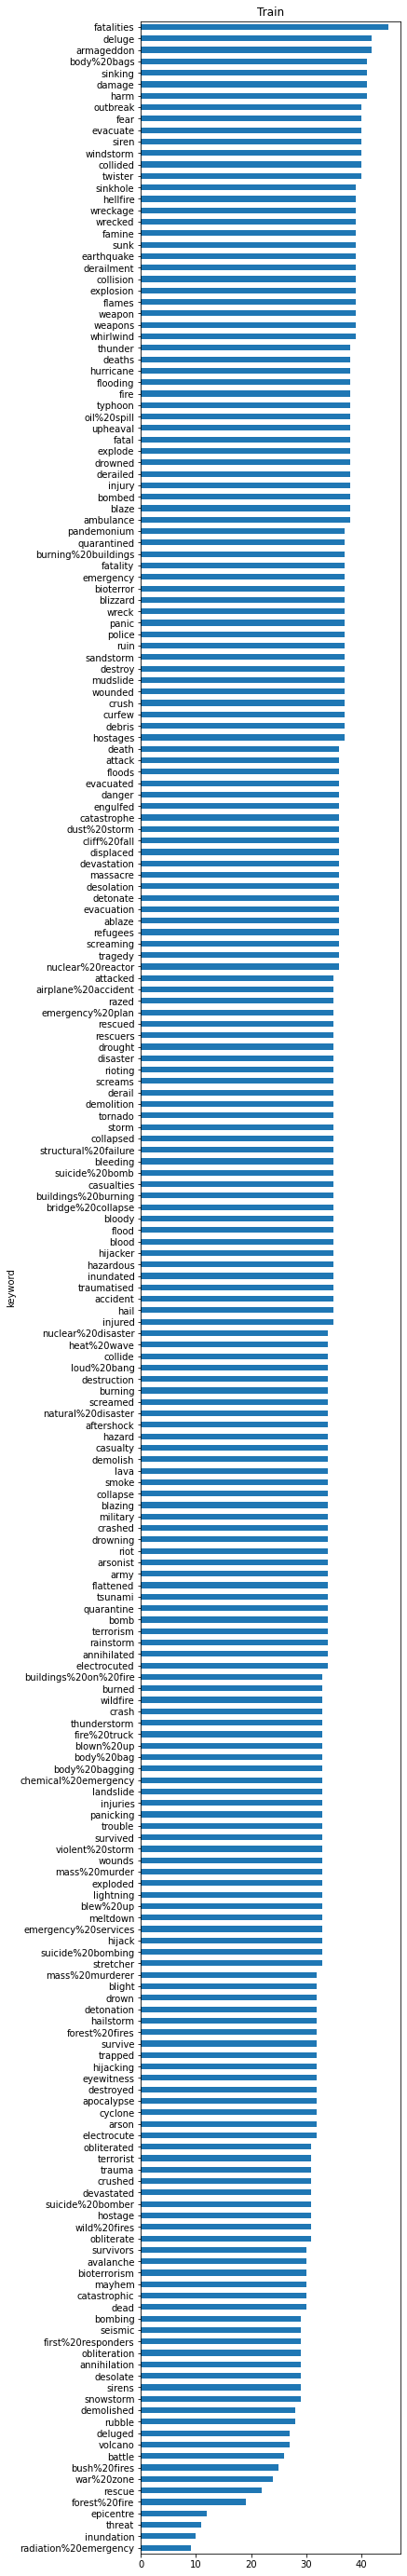

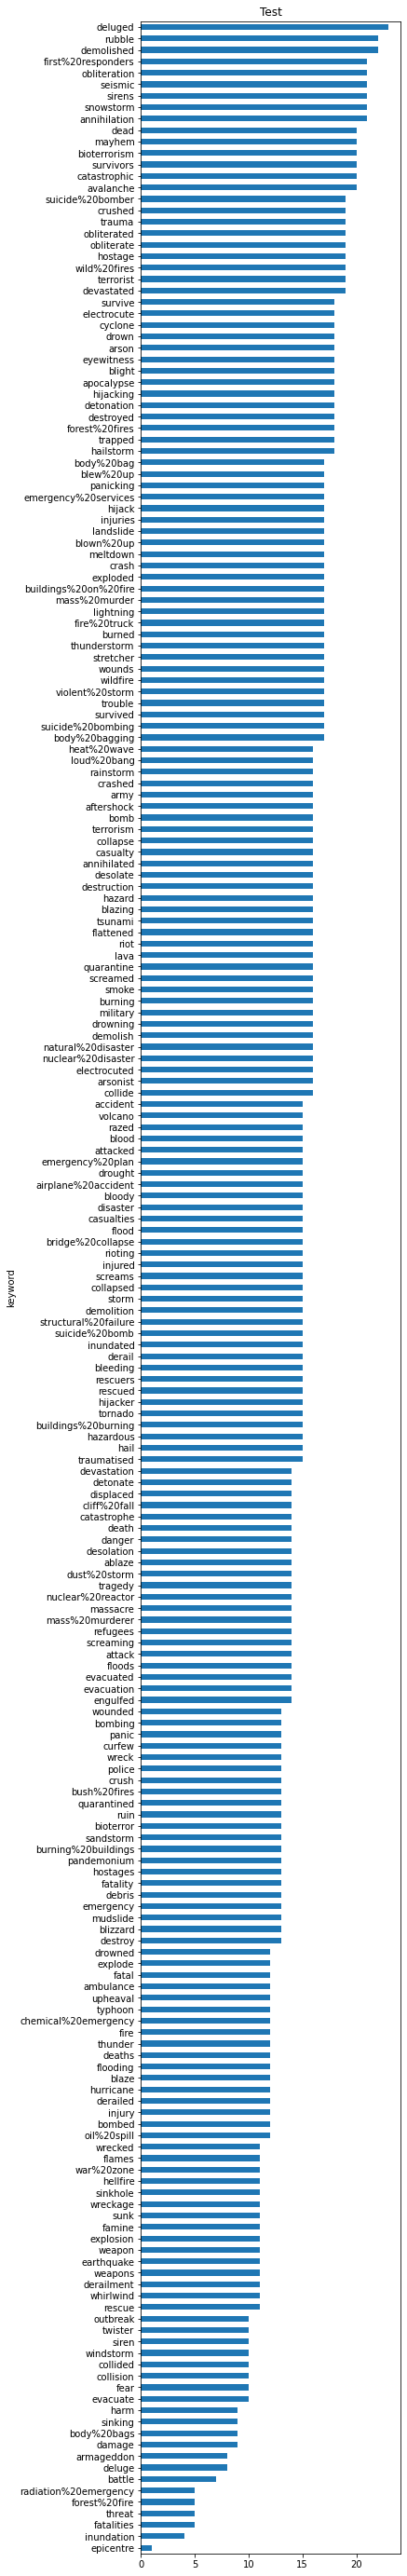

In [7]:
train["keyword"].reset_index().groupby("keyword").count().sort_values(by="index").plot(kind="barh", title='Train', legend=False, figsize=(5,50))
test["keyword"].reset_index().groupby("keyword").count().sort_values(by="index").plot(kind="barh", title='Test', legend=False, figsize=(5,50))

### 何語なのか判定

In [8]:
train['lang'] = train["text"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")

test['lang'] = train["text"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")

In [9]:
display(train.head())
print("train")
display(train["lang"].reset_index().groupby("lang").count().sort_values(by= "index", ascending=False))
print()
display(test.head)
print("test")
display(test["lang"].reset_index().groupby("lang").count().sort_values(by= "index", ascending=False))

,id,keyword,text,target,lang
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,en
2,5,NaN,All residents asked to 'shelter in place' are ...,1,en
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,en
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en


train


,index
lang,
en,7317
de,55
ca,23
da,21
it,18
af,17
no,16
sv,15
es,15


<bound method NDFrame.head of          id keyword                                               text lang
0         0     NaN                 Just happened a terrible car crash   en
1         2     NaN  Heard about #earthquake is different cities, s...   en
2         3     NaN  there is a forest fire at spot pond, geese are...   en
3         9     NaN           Apocalypse lighting. #Spokane #wildfires   en
4        11     NaN      Typhoon Soudelor kills 28 in China and Taiwan   en
...     ...     ...                                                ...  ...
3258  10861     NaN  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...   en
3259  10865     NaN  Storm in RI worse than last hurricane. My city...   en
3260  10868     NaN  Green Line derailment in Chicago http://t.co/U...   en
3261  10874     NaN  MEG issues Hazardous Weather Outlook (HWO) htt...   en
3262  10875     NaN  #CityofCalgary has activated its Municipal Eme...   en

[3263 rows x 4 columns]>

test


,index
lang,
en,3144
de,20
da,11
it,9
tl,9
sv,9
no,9
nl,7
ca,6


In [10]:
display(train[train["lang"] == "de"].head())
display(test[train["lang"] == "de"].head())

,id,keyword,text,target,lang
86,128,accident,FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;NHS;999...,1,de
89,131,accident,;ACCIDENT PROPERTY DAMAGE; PINER RD/HORNDALE DR,1,de
91,133,accident,FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;WPD;160...,1,de
200,281,ambulance,HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPOND...,0,de
239,340,annihilated,ANNIHILATED IN DAMASCUS: SYRIAN ARMY GRINDS Û...,1,de


,id,keyword,text,lang
86,295,ambulance,so privileged and proud to wear this uniform.?...,de
89,305,annihilated,Cop pulls drunk driver to safety SECONDS befor...,de
91,308,annihilated,@johnboywest The only 'stage' the drama queen ...,de
200,647,attack,Delhi government to provide free treatment to ...,de
239,769,avalanche,@Avalanche need anyone to carry your bag? ??,de


### 記号 （ ' や ! や その他諸々）の入ったテキストの確認
参考）正規表現の基本
https://qiita.com/grrrr/items/7c8811b5cf37d700adc4

In [11]:
print("train")
display(train[train["text"].str.contains(r'[^\s\w]')].head())
display(train[train["text"].str.contains(r'[^\s\w]')].tail())
display(train[train["text"].str.contains(r'[^\s\w]')]["text"].count().sum())
display(train[train["text"].str.contains(r'[^\s\w]')]["text"].count().sum()/train["text"].count().sum()*100)

print("test")
display(test[test["text"].str.contains(r'[^\s\w]')].head())
display(test[test["text"].str.contains(r'[^\s\w]')].tail())
display(test[test["text"].str.contains(r'[^\s\w]')]["text"].count().sum())
display(test[test["text"].str.contains(r'[^\s\w]')]["text"].count().sum()/test["text"].count().sum()*100)

train


,id,keyword,text,target,lang
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,en
2,5,NaN,All residents asked to 'shelter in place' are ...,1,en
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,en
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en


,id,keyword,text,target,lang
7608,10869,NaN,Two giant cranes holding a bridge collapse int...,1,en
7609,10870,NaN,@aria_ahrary @TheTawniest The out of control w...,1,en
7610,10871,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,en
7611,10872,NaN,Police investigating after an e-bike collided ...,1,en
7612,10873,NaN,The Latest: More Homes Razed by Northern Calif...,1,en


7277

95.58649678182057

test


,id,keyword,text,lang
1,2,NaN,"Heard about #earthquake is different cities, s...",en
2,3,NaN,"there is a forest fire at spot pond, geese are...",en
3,9,NaN,Apocalypse lighting. #Spokane #wildfires,en
5,12,NaN,We're shaking...It's an earthquake,en
6,21,NaN,They'd probably still show more life than Arse...,en


,id,keyword,text,lang
3258,10861,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,en
3259,10865,NaN,Storm in RI worse than last hurricane. My city...,en
3260,10868,NaN,Green Line derailment in Chicago http://t.co/U...,en
3261,10874,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,en
3262,10875,NaN,#CityofCalgary has activated its Municipal Eme...,en


3126

95.80140974563285

### 記号を削除

In [12]:
train['text_clean'] = train["text"].apply(lambda x: re.sub(r'[^\w\s]',
                                                     '', x).lower().strip())

test['text_clean'] = test["text"].apply(lambda x: re.sub(r'[^\w\s]',
                                                     '', x).lower().strip())

display(train.head())
display(test.head())

,id,keyword,text,target,lang,text_clean
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,our deeds are the reason of this earthquake ma...
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,en,forest fire near la ronge sask canada
2,5,NaN,All residents asked to 'shelter in place' are ...,1,en,all residents asked to shelter in place are be...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,en,13000 people receive wildfires evacuation orde...
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en,just got sent this photo from ruby alaska as s...


,id,keyword,text,lang,text_clean
0,0,NaN,Just happened a terrible car crash,en,just happened a terrible car crash
1,2,NaN,"Heard about #earthquake is different cities, s...",en,heard about earthquake is different cities sta...
2,3,NaN,"there is a forest fire at spot pond, geese are...",en,there is a forest fire at spot pond geese are ...
3,9,NaN,Apocalypse lighting. #Spokane #wildfires,en,apocalypse lighting spokane wildfires
4,11,NaN,Typhoon Soudelor kills 28 in China and Taiwan,en,typhoon soudelor kills 28 in china and taiwan


### トークン化

In [13]:
# text カラムを配列に変更
txt_train = train["text_clean"].values.tolist()
txt_test  = test["text_clean"].values.tolist()

In [14]:
# 単語に分解してトークン化
txt_train = [x.split() for x in txt_train]
txt_test = [x.split() for x in txt_test]

In [15]:
# リストの最初の要素を表示
display(txt_train[0])
display(txt_test[0])

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 'earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all']

['just', 'happened', 'a', 'terrible', 'car', 'crash']

### ストップワード
nltkでstopwordsの設定  
http://blog.livedoor.jp/oyajieng_memo/archives/2577889.html

In [16]:
# ストップワードリストの作成
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kojis\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
lst_stopwords[:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [18]:
# ストップワードの削除
for i in range(len(txt_train)):
    txt_train[i] = [word for word in txt_train[i] if word not in lst_stopwords]
    
for i in range(len(txt_test)):
    txt_test[i] = [word for word in txt_test[i] if word not in lst_stopwords]

In [19]:
display(txt_train[0])
display(txt_test[0])

['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']

['happened', 'terrible', 'car', 'crash']

In [20]:
### 以下、未了　貼り付けただけ

### 語幹の抽出
例：going --> go、unbelievable --> unbelieve

In [21]:
ps = nltk.stem.porter.PorterStemmer()

In [22]:
# 語幹の抽出
for i in range(len(txt_train)):
    txt_train[i] = [ps.stem(word) for word in txt_train[i]]
    
for i in range(len(txt_test)):
    txt_test[i] = [ps.stem(word) for word in txt_test[i]]

In [23]:
display(txt_train[0])
display(txt_test[0])

['deed', 'reason', 'earthquak', 'may', 'allah', 'forgiv', 'us']

['happen', 'terribl', 'car', 'crash']

### 見出し語化
その単語を、辞書に載っている形に従って分類すること  
[Python] NLTKを使ってみる (4)  
https://yottagin.com/?p=3218  
nltk.stem package  
https://www.nltk.org/api/nltk.stem.html#nltk-stem-package

In [24]:
lem = nltk.stem.wordnet.WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\kojis\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
# 見出し語化
for i in range(len(txt_train)):
    txt_train[i] = [lem.lemmatize(word) for word in txt_train[i]]
    
for i in range(len(txt_test)):
    txt_test[i] = [lem.lemmatize(word) for word in txt_test[i]]

In [26]:
display(txt_train[0])
display(txt_test[0])

['deed', 'reason', 'earthquak', 'may', 'allah', 'forgiv', 'u']

['happen', 'terribl', 'car', 'crash']

### 特徴量の作成

In [27]:
# 単語カウント数
train['word_count'] = train["text"].apply(lambda x: len(str(x).split(" ")))

# 文字カウント数
train['char_count'] = train["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

# 文章カウント数
train['sentence_count'] = train["text"].apply(lambda x: len(str(x).split(".")))

# 単語の文字数（平均）
train['avg_word_length'] = train['char_count'] / train['word_count']

# 文章の単語数（平均）
train['avg_sentence_lenght'] = train['word_count'] / train['sentence_count']

In [28]:
# 単語カウント数
test['word_count'] = test["text"].apply(lambda x: len(str(x).split(" ")))

# 文字カウント数
test['char_count'] = test["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))

# 文章カウント数
test['sentence_count'] = test["text"].apply(lambda x: len(str(x).split(".")))

# 単語の文字数（平均）
test['avg_word_length'] = test['char_count'] / test['word_count']

# 文章の単語数（平均）
test['avg_sentence_lenght'] = test['word_count'] / test['sentence_count']

In [29]:
display(train["text"][0])
display(train.head(1))
display(test["text"][0])
display(test.head(1))

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

,id,keyword,text,target,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,our deeds are the reason of this earthquake ma...,13,57,1,4.384615,13.0


'Just happened a terrible car crash'

,id,keyword,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,0,NaN,Just happened a terrible car crash,en,just happened a terrible car crash,6,29,1,4.833333,6.0


### 感情分析

In [30]:
# TextBlob().sentiment.polarityで感情分析
train["sentiment"] = train["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
test["sentiment"] = train["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [31]:
display(train.head(3))
display(test.head(3))

,id,keyword,text,target,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,our deeds are the reason of this earthquake ma...,13,57,1,4.384615,13.0,0.00000
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,en,forest fire near la ronge sask canada,7,32,2,4.571429,3.5,0.10000
2,5,NaN,All residents asked to 'shelter in place' are ...,1,en,all residents asked to shelter in place are be...,22,112,2,5.090909,11.0,-0.01875


,id,keyword,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
0,0,NaN,Just happened a terrible car crash,en,just happened a terrible car crash,6,29,1,4.833333,6.0,0.00000
1,2,NaN,"Heard about #earthquake is different cities, s...",en,heard about earthquake is different cities sta...,9,56,2,6.222222,4.5,0.10000
2,3,NaN,"there is a forest fire at spot pond, geese are...",en,there is a forest fire at spot pond geese are ...,19,78,1,4.105263,19.0,-0.01875


### タグ付け
事前にコマンド python -m spacy download en_core_web_lg で ダウンロードする必要あり  
install後は開発環境を立ち上げなおしましょう  

Spacy nlp = spacy.load(“en_core_web_lg”)  
https://stackoverflow.com/questions/56470403/spacy-nlp-spacy-loaden-core-web-lg  

spaCyを使ってルールベースの記述をシンプルに！  
https://qiita.com/moriyamanaoto/items/e98b8a6ff1c8fcf8e293  
spaCy.displacy.render Jupyter環境で可視化  

ディープラーニングで作る固有表現認識器  
https://bit.ly/30JUk2C  
固有表現認識とは、テキストに出現する人名や地名などの固有名詞や、日付や時間などの数値表現を認識する技術のこと

In [32]:
nlp = spacy.load("en_core_web_lg")

In [33]:
# 固有表現認識
train["tags"] = train["text"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in nlp(x).ents])

test["tags"] = test["text"].apply(lambda x: [(tag.text, tag.label_) 
                                for tag in nlp(x).ents])

In [34]:
display(train.head(3))
display(test.head(3))

,id,keyword,text,target,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,tags
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,en,our deeds are the reason of this earthquake ma...,13,57,1,4.384615,13.0,0.00000,[]
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,en,forest fire near la ronge sask canada,7,32,2,4.571429,3.5,0.10000,"[(La Ronge Sask, LOC), (Canada, GPE)]"
2,5,NaN,All residents asked to 'shelter in place' are ...,1,en,all residents asked to shelter in place are be...,22,112,2,5.090909,11.0,-0.01875,[]


,id,keyword,text,lang,text_clean,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment,tags
0,0,NaN,Just happened a terrible car crash,en,just happened a terrible car crash,6,29,1,4.833333,6.0,0.00000,[]
1,2,NaN,"Heard about #earthquake is different cities, s...",en,heard about earthquake is different cities sta...,9,56,2,6.222222,4.5,0.10000,"[(about #, CARDINAL)]"
2,3,NaN,"there is a forest fire at spot pond, geese are...",en,there is a forest fire at spot pond geese are ...,19,78,1,4.105263,19.0,-0.01875,[]


### ワードクラウド

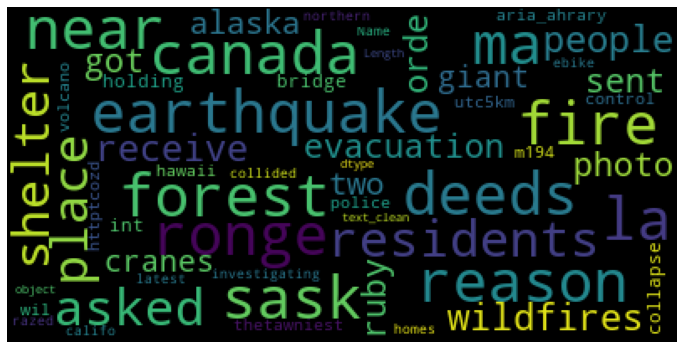

In [35]:
corpus = train["text_clean"]

wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))

fig = plt.figure(figsize=(12.0, 8.0), num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

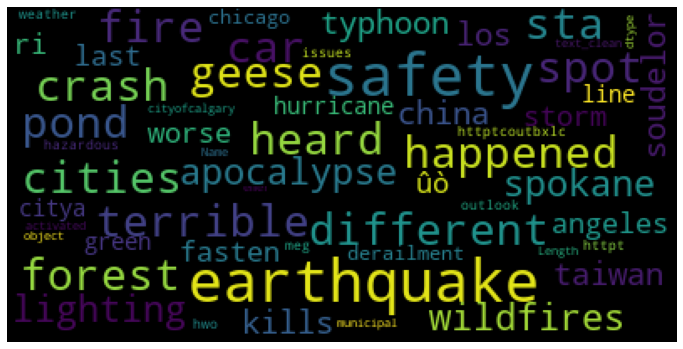

In [36]:
corpus = test["text_clean"]

wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))

fig = plt.figure(figsize=(12.0, 8.0), num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

### 単語ベクタライズ word embeddings

単語埋め込み (Word embeddings)  
https://www.tensorflow.org/tutorials/text/word_embeddings?hl=ja  
単語埋め込みを使うと、似たような単語が似たようにエンコードされる、効率的で密な表現が得られます。  

glove-wiki-gigaword-300 とは？  
Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)  
サイズ300の単語のベクトル表現を取得するための教師なし学習アルゴリズム  
このオブジェクトを使用して、単語をベクトルにマッピングできる  

Gensim data  
https://github.com/RaRe-Technologies/gensim-data  
実行すると376.1MBのデータのダウンロードが始まる  

In [37]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [38]:
### 単語を選択
word = "dance"

In [39]:
display(nlp[word])
display(nlp[word].shape)

array([-0.036239 , -0.32319  ,  0.14688  , -0.033678 , -0.27969  ,
       -0.30298  , -0.171    ,  0.12303  , -0.16148  ,  0.01389  ,
        0.03132  , -0.043067 , -0.14635  ,  0.5387   ,  0.56385  ,
       -0.1672   , -0.054608 ,  0.12886  ,  0.21586  ,  0.40894  ,
       -0.17282  ,  0.64315  ,  0.3903   ,  0.62477  ,  0.11772  ,
        0.31874  ,  0.40439  , -0.48866  , -0.34325  ,  1.1242   ,
       -0.31061  , -0.37843  , -0.080358 ,  0.074448 , -1.1881   ,
        0.56299  ,  0.54291  ,  0.57072  ,  0.086793 , -0.050855 ,
       -0.12809  , -0.11143  , -0.66469  ,  0.1991   ,  0.40602  ,
        0.18675  ,  0.67327  , -0.27722  ,  0.18507  ,  0.076922 ,
        0.1352   , -0.16834  , -0.11442  ,  0.076865 , -0.37275  ,
        0.02959  , -0.44473  , -0.24564  ,  0.69519  ,  0.35594  ,
        0.15441  ,  0.42487  ,  0.71756  ,  0.44067  , -0.37545  ,
       -0.039047 ,  0.75805  ,  0.37323  , -0.0023207,  0.68466  ,
       -0.46873  ,  0.047377 , -0.52156  , -0.27165  , -0.0913

(300,)

gensim.models.Word2Vec.most_similar()  
上位N個の最も類似した単語を見つけます。  
https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html  

In [40]:
labels, X, x, y = [], [], [], []

for t in nlp.most_similar(word, topn=20):
    X.append(nlp[t[0]])
    labels.append(t[0])

t-SNE [1]は、高次元データを視覚化するためのツールです。  
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html  
fit_transform()の使い方  
https://bunseki-train.com/t-sne-code-example/  

In [41]:
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')

new_values = pca.fit_transform(X)
for value in new_values:
    x.append(value[0])
    y.append(value[1])

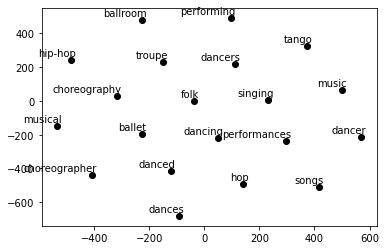

In [42]:
## グラフ
fig = plt.figure()
for i in range(len(x)):
    plt.scatter(x[i], y[i], c="black")
    plt.annotate(labels[i], xy=(x[i],y[i]), xytext=(5,2), 
               textcoords='offset points', ha='right', va='bottom')

Text(5, 2, 'dance')

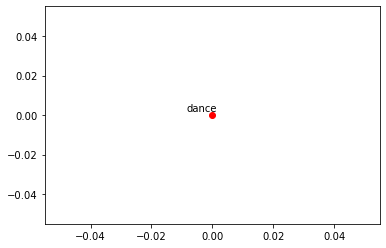

In [43]:
## add center
plt.scatter(x=0, y=0, c="red")

## .annotate() 矢印の描画、名称(love)を追記
## https://qiita.com/haru1843/items/e85fe45163cd9763023c
plt.annotate(word, xy=(0,0), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

### LDAモデル

In [44]:
corpus = train["text_clean"]

## 前処理
lst_corpus = []

for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)

In [45]:
## 単語をＩＤに対応付ける
id2word = gensim.corpora.Dictionary(lst_corpus)

In [46]:
## 単語の頻出数の作成
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] 

LDA は1つの文書が複数のトピックから成ることを仮定した言語モデルの一種です。  
日本語だと「潜在的ディリクレ配分法」と呼ばれます。単語などを表層的と表現するならば、トピックは単語と違って表面には現れないので潜在的です。その潜在的な要素の分布の事前分布にディリクレ分布を仮定してごにょごにょするから「潜在的ディリクレ配分法」と呼ぶのかなぁと思ってます。  

Latent Dirichlet Allocation (LDA) ゆるふわ入門  
https://bit.ly/330iXuq  

gensim.models.ldamodel.LdaModel LDAモデル  
https://fits.hatenablog.com/entry/2018/03/13/214609  

In [50]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=3, 
                                            random_state=42, update_every=1, chunksize=100, 
                                            passes=10, alpha='auto', per_word_topics=True)

In [51]:
lst_dics = []
for i in range(0,3):
    # get_topics() 「トピック数×語彙数」の行列を返す。
    # http://kento1109.hatenablog.com/entry/2017/12/27/114811
    lst_tuples = lda_model.get_topic_terms(i)
    
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
        
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

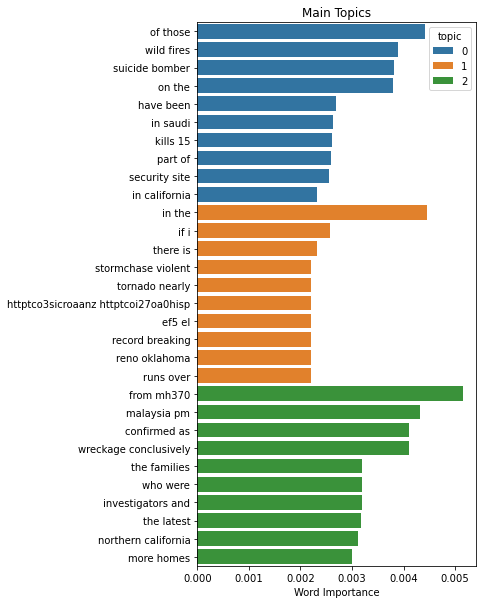

In [52]:
## グラフ
fig, ax = plt.subplots(figsize=(5, 10))
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()